---
## Step 1: Setup and Imports

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Add parent directory for MAPS import
sys.path.insert(0, '..')

# Clear cached imports
for mod_name in list(sys.modules.keys()):
    if 'MAPS' in mod_name or 'maps' in mod_name:
        del sys.modules[mod_name]

from MAPS.cell_phenotyping import Trainer, Predictor

print("✅ All imports successful!")
print(f"📂 Working directory: {os.getcwd()}")

✅ All imports successful!
📂 Working directory: c:\Users\mahee\OneDrive\Documents\Semester-12\FYDP-2\MAPS\Experiments_my_ideas


In [2]:
# Check GPU
print("🖥️ Hardware Check:")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA version: {torch.version.cuda}")
    device = torch.device('cuda')
else:
    print("   Running on CPU")
    device = torch.device('cpu')

🖥️ Hardware Check:
   CUDA available: True
   GPU: NVIDIA GeForce GTX 1650
   CUDA version: 12.1


---
## Step 2: Load Original Dataset and Compute Spatial Features

In [3]:
# Load the original annotation CSV (has X_cent, Y_cent)
csv_path = '../cHL_CODEX/annotation_csv/cHL_CODEX_annotation.csv'

print("📂 Loading original dataset...")
dataset = pd.read_csv(csv_path)

print(f"✅ Dataset loaded!")
print(f"   Shape: {dataset.shape}")
print(f"   Cells: {dataset.shape[0]:,}")
print(f"\n   Available columns: {list(dataset.columns[:10])}...")

# Check if we have coordinates
if 'X_cent' in dataset.columns and 'Y_cent' in dataset.columns:
    print(f"\n✅ Spatial coordinates found!")
    print(f"   X range: [{dataset['X_cent'].min():.1f}, {dataset['X_cent'].max():.1f}]")
    print(f"   Y range: [{dataset['Y_cent'].min():.1f}, {dataset['Y_cent'].max():.1f}]")
else:
    print("\n⚠️ Warning: X_cent or Y_cent not found!")

📂 Loading original dataset...
✅ Dataset loaded!
   Shape: (145161, 54)
   Cells: 145,161

   Available columns: ['cellLabel', 'X_cent', 'Y_cent', 'cellSize', 'cellType', 'BCL.2', 'CCR6', 'CD11b', 'CD11c', 'CD15']...

✅ Spatial coordinates found!
   X range: [3.0, 8083.0]
   Y range: [2.0, 8006.0]


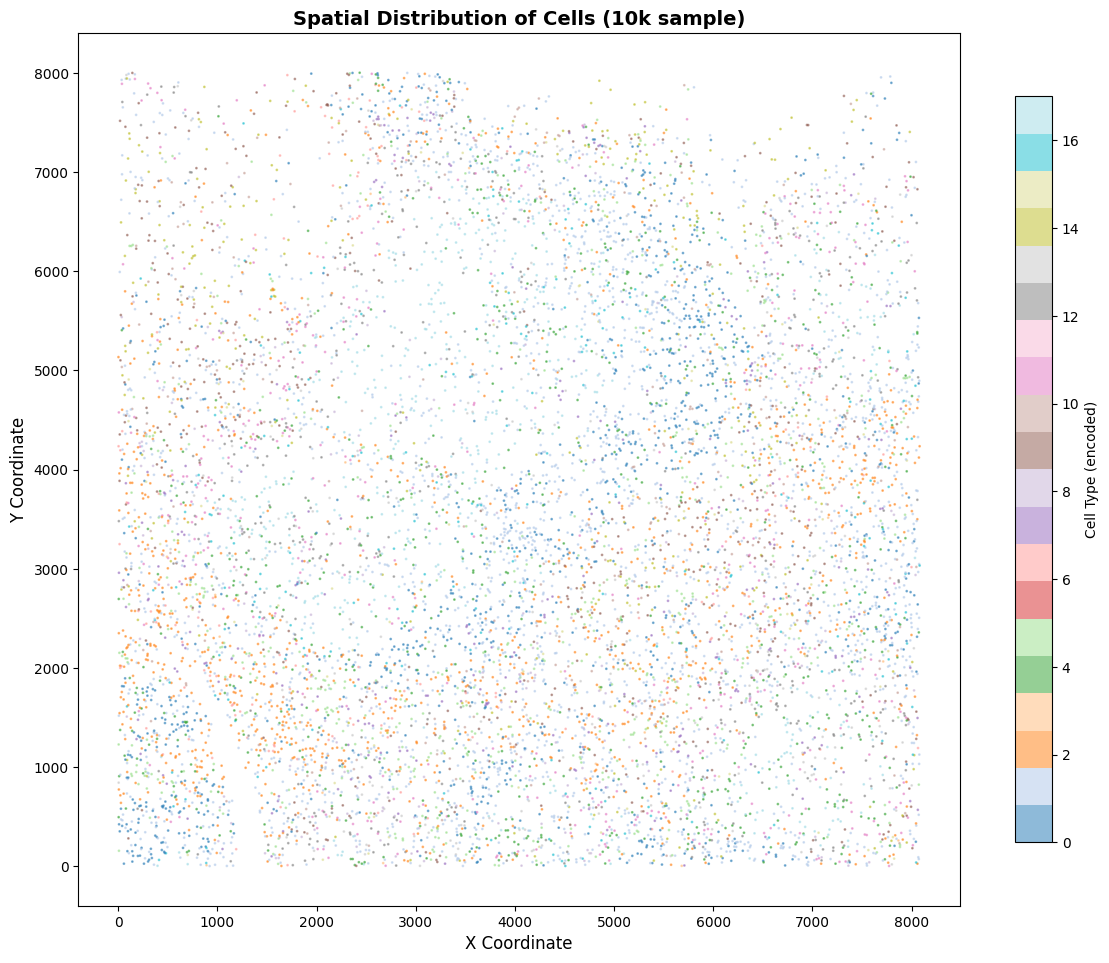

💡 Each dot = one cell. Colors = different cell types.
   Look for spatial patterns (clustering, regions, etc.)


In [4]:
# Visualize cell spatial distribution
plt.figure(figsize=(12, 10))

# Sample for visualization (plot max 10k cells for performance)
sample_size = min(10000, len(dataset))
sample_indices = np.random.choice(len(dataset), sample_size, replace=False)
sample_data = dataset.iloc[sample_indices]

plt.scatter(sample_data['X_cent'], sample_data['Y_cent'], 
           c=sample_data['cellType'].astype('category').cat.codes,
           cmap='tab20', alpha=0.5, s=1)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.title('Spatial Distribution of Cells (10k sample)', fontsize=14, fontweight='bold')
plt.colorbar(label='Cell Type (encoded)', shrink=0.8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

print("💡 Each dot = one cell. Colors = different cell types.")
print("   Look for spatial patterns (clustering, regions, etc.)")

---
## Step 3: Engineer Spatial Features

We'll create four spatial features:
1. **`X_cent`** - Raw X coordinate (normalized)
2. **`Y_cent`** - Raw Y coordinate (normalized)
3. **`local_density`** - Number of neighbors within 50 pixels
4. **`distance_to_center`** - Distance from tissue center (normalized)

In [5]:
print("🔧 Engineering spatial features...\n")

# Clean dataset (same preprocessing as before)
print("Step 1: Cleaning dataset...")
if 'Seg Artifact' in dataset['cellType'].values:
    dataset = dataset[dataset['cellType'] != 'Seg Artifact']
    print(f"   Removed 'Seg Artifact' cells")

if 'Cytotoxic CD8' in dataset['cellType'].values:
    dataset.loc[dataset['cellType'] == 'Cytotoxic CD8', 'cellType'] = 'CD8'
    print(f"   Merged 'Cytotoxic CD8' → 'CD8'")

dataset.reset_index(inplace=True, drop=True)
print(f"   Final count: {len(dataset):,} cells")

🔧 Engineering spatial features...

Step 1: Cleaning dataset...
   Removed 'Seg Artifact' cells
   Merged 'Cytotoxic CD8' → 'CD8'
   Final count: 143,730 cells


In [6]:
# Feature 3: Local Density (number of neighbors within radius)
print("\nStep 2: Computing local density...")
print("   (This may take 1-2 minutes for 100K cells)")

start_time = time.time()

# Extract coordinates
coords = dataset[['X_cent', 'Y_cent']].values

# Use radius-based neighbors (faster than KNN for large datasets)
RADIUS = 50  # pixels - adjust based on your tissue resolution
nbrs = NearestNeighbors(radius=RADIUS, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.radius_neighbors(coords)

# Count neighbors (excluding self)
local_densities = [len(neighbors) - 1 for neighbors in indices]
dataset['local_density'] = local_densities

elapsed = time.time() - start_time
print(f"✅ Local density computed in {elapsed:.1f}s")
print(f"   Min density: {min(local_densities)}")
print(f"   Max density: {max(local_densities)}")
print(f"   Mean density: {np.mean(local_densities):.1f}")
print(f"   (Higher = more crowded region)")


Step 2: Computing local density...
   (This may take 1-2 minutes for 100K cells)
✅ Local density computed in 0.4s
   Min density: 0
   Max density: 36
   Mean density: 19.7
   (Higher = more crowded region)


In [7]:
# Feature 4: Distance to tissue center
print("\nStep 3: Computing distance to tissue center...")

# Find tissue center (mean of all cell positions)
center_x = dataset['X_cent'].mean()
center_y = dataset['Y_cent'].mean()

print(f"   Tissue center: ({center_x:.1f}, {center_y:.1f})")

# Compute distance from each cell to center
dataset['distance_to_center'] = np.sqrt(
    (dataset['X_cent'] - center_x)**2 + 
    (dataset['Y_cent'] - center_y)**2
)

print(f"✅ Distance computed")
print(f"   Min: {dataset['distance_to_center'].min():.1f}")
print(f"   Max: {dataset['distance_to_center'].max():.1f}")
print(f"   Mean: {dataset['distance_to_center'].mean():.1f}")


Step 3: Computing distance to tissue center...
   Tissue center: (4055.4, 3419.6)
✅ Distance computed
   Min: 8.8
   Max: 6096.9
   Mean: 2949.6


In [8]:
# Re-sample after cleaning for visualization
print("\n🎨 Preparing visualization sample...")
sample_size = min(10000, len(dataset))
sample_indices = np.random.choice(len(dataset), sample_size, replace=False)
sample_data = dataset.iloc[sample_indices]
print(f"   Sampled {sample_size:,} cells for visualization")


🎨 Preparing visualization sample...
   Sampled 10,000 cells for visualization


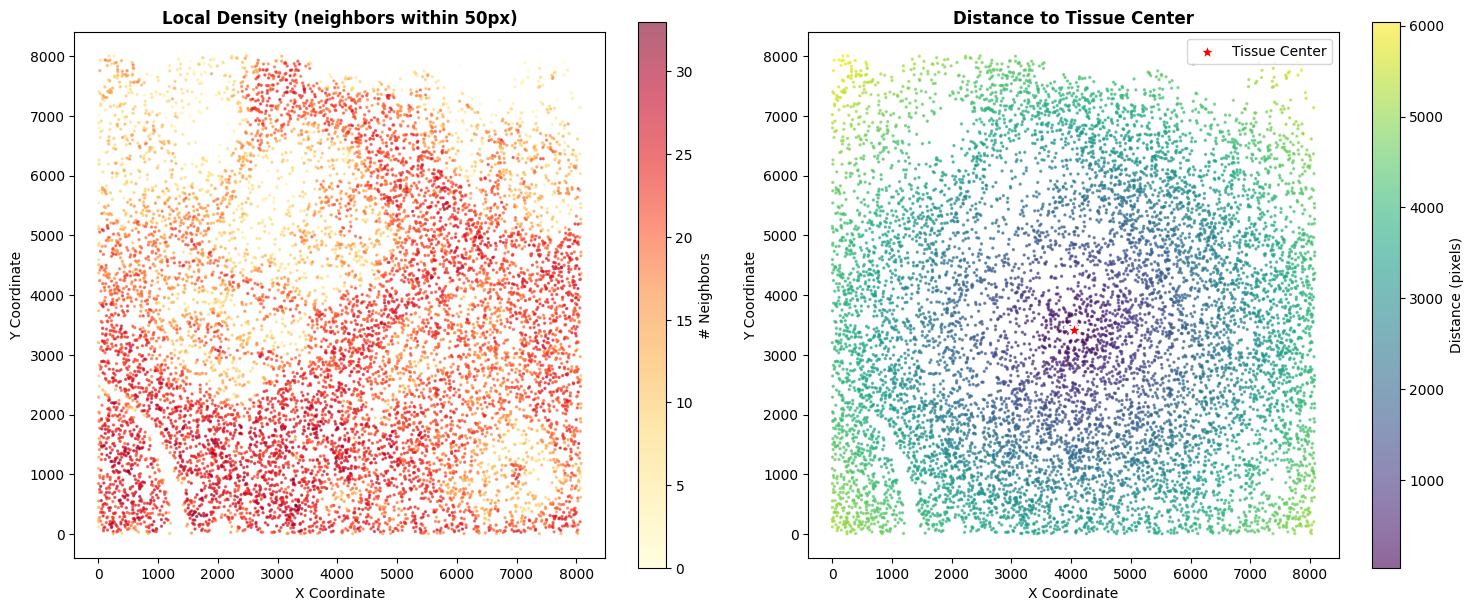


💡 Observations to look for:
   - Are dense regions different cell types?
   - Do certain cell types cluster at center vs periphery?


In [9]:
# Visualize spatial features
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Local density heatmap
scatter1 = axes[0].scatter(sample_data['X_cent'], sample_data['Y_cent'],
                          c=dataset.loc[sample_indices, 'local_density'],
                          cmap='YlOrRd', alpha=0.6, s=2)
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].set_title('Local Density (neighbors within 50px)', fontweight='bold')
axes[0].set_aspect('equal', adjustable='box')
plt.colorbar(scatter1, ax=axes[0], label='# Neighbors')

# Plot 2: Distance to center
scatter2 = axes[1].scatter(sample_data['X_cent'], sample_data['Y_cent'],
                          c=dataset.loc[sample_indices, 'distance_to_center'],
                          cmap='viridis', alpha=0.6, s=2)
axes[1].scatter(center_x, center_y, c='red', s=200, marker='*', 
               edgecolors='white', linewidths=2, label='Tissue Center')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')
axes[1].set_title('Distance to Tissue Center', fontweight='bold')
axes[1].set_aspect('equal', adjustable='box')
axes[1].legend()
plt.colorbar(scatter2, ax=axes[1], label='Distance (pixels)')

plt.tight_layout()
plt.show()

print("\n💡 Observations to look for:")
print("   - Are dense regions different cell types?")
print("   - Do certain cell types cluster at center vs periphery?")

---
## Step 4: Prepare Dataset with Spatial Features

In [10]:
# Create class mapping
print("🗂️ Creating class mappings...")

class_dict = {'class_id': [], 'class_name': [], 'sample_count': []}
class_mapping = {}

for i, class_name in enumerate(sorted(dataset['cellType'].unique())):
    class_dict['class_id'].append(i)
    class_dict['class_name'].append(class_name)
    class_dict['sample_count'].append(np.sum(dataset['cellType'] == class_name))
    class_mapping[class_name] = i

class_df = pd.DataFrame(class_dict)
print("\nClass Mapping:")
print(class_df.to_string(index=False))

NUM_CLASSES = len(class_mapping)

🗂️ Creating class mappings...

Class Mapping:
 class_id  class_name  sample_count
        0           B         16196
        1         CD4         37480
        2         CD8         17568
        3          DC          9637
        4 Endothelial          8705
        5  Epithelial          2251
        6   Lymphatic          3768
        7          M1          3101
        8          M2          7286
        9        Mast          3324
       10    Monocyte          6913
       11          NK          7339
       12  Neutrophil          3442
       13       Other          5108
       14        TReg          3352
       15       Tumor          8260


In [11]:
# Extract features WITH spatial information
print("\n🎯 Extracting features...")

# Identify marker columns
non_marker_cols = ['X_cent', 'Y_cent', 'cellLabel', 'cellSize', 'cellType', 
                   'local_density', 'distance_to_center']
marker_names = [col for col in dataset.columns if col not in non_marker_cols]
marker_names = sorted(marker_names)

print(f"\n📊 Feature Composition:")
print(f"   Protein markers: {len(marker_names)}")
print(f"   + cellSize: 1")
print(f"   + X_cent: 1")
print(f"   + Y_cent: 1")
print(f"   + local_density: 1")
print(f"   + distance_to_center: 1")
print(f"   ─────────────────────")
print(f"   TOTAL FEATURES: {len(marker_names) + 5}")
print(f"\n   (Standard MAPS uses only {len(marker_names) + 1} features)")

NUM_FEATURES = len(marker_names) + 5


🎯 Extracting features...

📊 Feature Composition:
   Protein markers: 49
   + cellSize: 1
   + X_cent: 1
   + Y_cent: 1
   + local_density: 1
   + distance_to_center: 1
   ─────────────────────
   TOTAL FEATURES: 54

   (Standard MAPS uses only 50 features)


In [12]:
# Create feature matrix WITH spatial features
print("\n🔧 Building feature matrix...")

features_cols = marker_names + ['cellSize', 'X_cent', 'Y_cent', 
                                 'local_density', 'distance_to_center']
features = dataset[features_cols].copy()
labels = np.array([class_mapping[class_name] for class_name in dataset['cellType']])
features['cell_label'] = labels

print(f"✅ Feature matrix created")
print(f"   Shape: {features.shape}")
print(f"   Features: {len(features_cols)}")
print(f"   Labels: {len(np.unique(labels))} classes")


🔧 Building feature matrix...
✅ Feature matrix created
   Shape: (143730, 55)
   Features: 54
   Labels: 16 classes


---
## Step 5: Create Train/Valid Splits

In [13]:
from sklearn.model_selection import StratifiedKFold

print("📂 Creating train/validation splits...")

# Create output directory
output_dir = './cHL_CODEX_spatial_features'
os.makedirs(output_dir, exist_ok=True)

# Stratified split (80/20)
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
train_index, valid_index = next(skf.split(features.to_numpy()[:, :-1], labels))

train_split = features.iloc[train_index]
valid_split = features.iloc[valid_index]

# Save splits
train_path = os.path.join(output_dir, 'train.csv')
valid_path = os.path.join(output_dir, 'valid.csv')

train_split.to_csv(train_path, index=False)
valid_split.to_csv(valid_path, index=False)

print(f"\n✅ Splits created!")
print(f"   Training set: {len(train_split):,} cells ({len(train_split)/len(features)*100:.1f}%)")
print(f"   Validation set: {len(valid_split):,} cells ({len(valid_split)/len(features)*100:.1f}%)")
print(f"\n📁 Saved to:")
print(f"   Train: {train_path}")
print(f"   Valid: {valid_path}")

# Save class mapping
class_df.to_csv(os.path.join(output_dir, 'class_names.csv'), index=False)

📂 Creating train/validation splits...

✅ Splits created!
   Training set: 114,984 cells (80.0%)
   Validation set: 28,746 cells (20.0%)

📁 Saved to:
   Train: ./cHL_CODEX_spatial_features\train.csv
   Valid: ./cHL_CODEX_spatial_features\valid.csv


---
## Step 6: Define Custom Dataset Class (with Spatial Features)

We need a custom dataset loader because MAPS's loader expects only 50 features,
but we now have 54 features (including spatial).

In [14]:
class SpatialCellDataset(Dataset):
    """
    Dataset for cell expression data WITH spatial features
    """
    def __init__(self, csv_file, is_train=True, mean=None, std=None):
        self.data = pd.read_csv(csv_file)
        self.is_train = is_train
        
        # Separate features and labels
        self.labels = self.data['cell_label'].values
        self.features = self.data.drop('cell_label', axis=1).values
        
        # Z-score normalization
        if is_train:
            self.mean = np.mean(self.features, axis=0)
            self.std = np.std(self.features, axis=0) + 1e-8
        else:
            if mean is None or std is None:
                raise ValueError("Must provide mean and std for validation set")
            self.mean = mean
            self.std = std
        
        self.features = (self.features - self.mean) / self.std
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float64),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )

print("✅ Custom dataset class defined!")

✅ Custom dataset class defined!


---
## Step 7: Train Model with Spatial Features

In [15]:
# Configuration
BATCH_SIZE = 512 if torch.cuda.is_available() else 128
LEARNING_RATE = 0.001
DROPOUT = 0.10
MAX_EPOCHS = 100
MIN_EPOCHS = 20
PATIENCE = 20
SEED = 42

print("⚙️ Training Configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Max epochs: {MAX_EPOCHS}")
print(f"   Patience: {PATIENCE}")
print(f"   Device: {device}")

⚙️ Training Configuration:
   Batch size: 512
   Learning rate: 0.001
   Max epochs: 100
   Patience: 20
   Device: cuda


In [16]:
# Set seeds
import random

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("✅ Seeds set for reproducibility")

✅ Seeds set for reproducibility


In [17]:
# Load datasets
print("📂 Loading datasets with spatial features...")

train_dataset = SpatialCellDataset(train_path, is_train=True)
valid_dataset = SpatialCellDataset(valid_path, is_train=False,
                                   mean=train_dataset.mean,
                                   std=train_dataset.std)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                         shuffle=True, num_workers=4 if torch.cuda.is_available() else 0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=4 if torch.cuda.is_available() else 0)

print(f"✅ Data loaded!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Valid batches: {len(valid_loader)}")
print(f"   Features per cell: {train_dataset.features.shape[1]}")

📂 Loading datasets with spatial features...
✅ Data loaded!
   Train batches: 225
   Valid batches: 57
   Features per cell: 54


In [18]:
# Define 4-layer MLP (same as MAPS, but with 54 input features)
class MLP_Spatial(nn.Module):
    def __init__(self, input_dim=54, hidden_dim=512, num_classes=16, dropout=0.10):
        super(MLP_Spatial, self).__init__()
        
        self.fc = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            # Layer 2
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            # Layer 3
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            # Layer 4
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, batch):
        features = self.fc(batch)
        logits = self.classifier(features)
        probs = torch.softmax(logits, dim=-1)
        return logits, probs

print("✅ Model architecture defined (4-layer MLP with spatial features)")

✅ Model architecture defined (4-layer MLP with spatial features)


In [19]:
# Initialize model
print("\n🚀 Initializing model...")

model = MLP_Spatial(input_dim=NUM_FEATURES, hidden_dim=512,
                   num_classes=NUM_CLASSES, dropout=DROPOUT)
model.to(device, dtype=torch.float64)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("✅ Model initialized!")
print(f"   Input features: {NUM_FEATURES} (50 markers + 4 spatial)")
print(f"   Hidden units: 512")
print(f"   Output classes: {NUM_CLASSES}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Device: {next(model.parameters()).device}")


🚀 Initializing model...
✅ Model initialized!
   Input features: 54 (50 markers + 4 spatial)
   Hidden units: 512
   Output classes: 16
   Parameters: 824,336
   Device: cuda:0


In [20]:
# Training functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for features, labels in loader:
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits, probs = model(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in loader:
            features = features.to(device)
            labels = labels.to(device)
            
            logits, probs = model(features)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels

print("✅ Training functions defined!")

✅ Training functions defined!


In [ ]:
# Train the model
print("\n" + "="*60)
print("TRAINING MODEL WITH SPATIAL FEATURES")
print("="*60)

results_dir = './results_spatial_features/'
os.makedirs(results_dir, exist_ok=True)

history = {
    'train_loss': [], 'train_acc': [],
    'valid_loss': [], 'valid_acc': []
}

best_valid_loss = float('inf')
patience_counter = 0
best_model_path = os.path.join(results_dir, 'best_spatial_model.pt')

start_time = time.time()

for epoch in range(MAX_EPOCHS):
    epoch_start = time.time()
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc, _, _ = validate_epoch(model, valid_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1:3d}/{MAX_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Valid Loss: {valid_loss:.4f} Acc: {valid_acc:.4f} | "
          f"Time: {epoch_time:.1f}s")
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_mean': train_dataset.mean,
            'train_std': train_dataset.std,
            'valid_loss': valid_loss,
            'valid_acc': valid_acc,
            'num_features': NUM_FEATURES
        }, best_model_path)
        print(f"  → 💾 Saved best model (valid_loss: {valid_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE and epoch >= MIN_EPOCHS:
            print(f"\n⏹️  Early stopping triggered after {epoch+1} epochs")
            break

training_time = time.time() - start_time

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print(f"\n⏱️  Total time: {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"📊 Epochs: {len(history['train_loss'])}")
print(f"🎯 Best valid loss: {best_valid_loss:.4f}")

# Save logs
history_df = pd.DataFrame(history)
history_df.to_csv(os.path.join(results_dir, 'training_logs.csv'), index=False)
print(f"💾 Logs saved to: {results_dir}training_logs.csv")


TRAINING MODEL WITH SPATIAL FEATURES


---
## Step 8: Visualize Training Progress

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Training', linewidth=2)
axes[0].plot(epochs, history['valid_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model with Spatial Features: Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Training', linewidth=2)
axes[1].plot(epochs, history['valid_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model with Spatial Features: Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Training Summary:")
print(f"   Final train accuracy: {history['train_acc'][-1]:.4f}")
print(f"   Final valid accuracy: {history['valid_acc'][-1]:.4f}")
print(f"   Best valid accuracy: {max(history['valid_acc']):.4f}")

---
## Step 9: Evaluate and Compare with Baseline

In [ ]:
# Load best spatial model
print("📦 Loading best spatial model...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded from epoch {checkpoint['epoch']+1}")

# Get predictions
_, _, pred_labels_spatial, gt_labels = validate_epoch(model, valid_loader, criterion, device)
accuracy_spatial = accuracy_score(gt_labels, pred_labels_spatial)

print(f"\n🎯 SPATIAL MODEL ACCURACY: {accuracy_spatial:.4f} ({accuracy_spatial*100:.2f}%)")

In [ ]:
# Load baseline model (4-layer without spatial features)
baseline_model_path = './results_new_model/best_checkpoint.pt'

if os.path.exists(baseline_model_path):
    print("\n📦 Loading baseline model (no spatial features)...")
    
    # Need to use MAPS Predictor with baseline data
    baseline_data_path = './cHL_CODEX_processed/valid.csv'
    
    if os.path.exists(baseline_data_path):
        baseline_predictor = Predictor(
            model_checkpoint_path=baseline_model_path,
            num_features=50,  # Original features
            num_classes=NUM_CLASSES,
            batch_size=BATCH_SIZE
        )
        
        pred_labels_baseline, _ = baseline_predictor.predict(baseline_data_path)
        accuracy_baseline = accuracy_score(gt_labels, pred_labels_baseline)
        
        print(f"✅ Baseline loaded")
        print(f"\n🎯 BASELINE ACCURACY: {accuracy_baseline:.4f} ({accuracy_baseline*100:.2f}%)")
    else:
        print(f"⚠️ Baseline data not found at {baseline_data_path}")
        accuracy_baseline = None
        pred_labels_baseline = None
else:
    print(f"\n⚠️ Baseline model not found. Run 'cHL_CODEX_training_comparison.ipynb' first.")
    accuracy_baseline = None
    pred_labels_baseline = None

In [ ]:
# Comparison
if accuracy_baseline is not None:
    print("\n" + "="*70)
    print("MODEL COMPARISON: SPATIAL vs BASELINE")
    print("="*70)
    
    print(f"\n🌍 WITH Spatial Features:        {accuracy_spatial:.4f} ({accuracy_spatial*100:.2f}%)")
    print(f"📊 WITHOUT Spatial Features:     {accuracy_baseline:.4f} ({accuracy_baseline*100:.2f}%)")
    
    improvement = (accuracy_spatial - accuracy_baseline) * 100
    print(f"\n📈 IMPROVEMENT: {improvement:+.2f}%")
    
    if improvement > 0.5:
        print("\n🎉 SUCCESS! Spatial features provide meaningful improvement!")
        print("💡 Spatial context helps the model understand cell relationships.")
    elif improvement > 0:
        print("\n✅ Slight improvement. Spatial features help a bit.")
        print("💡 Consider: May need more spatial features or different architecture.")
    else:
        print("\n⚠️ No improvement. Spatial features didn't help.")
        print("💡 Possible reasons:")
        print("   - Cells are randomly distributed (no spatial patterns)")
        print("   - Cell type is purely intrinsic (markers alone suffice)")
        print("   - Need different spatial features (e.g., neighbor cell types)")

---
## Step 10: Per-Class Analysis

In [ ]:
# Classification report
print("\n📋 CLASSIFICATION REPORT (Spatial Model):")
print("="*70)
print(classification_report(gt_labels, pred_labels_spatial,
                          target_names=class_df['class_name'].tolist(),
                          digits=3))

In [ ]:
# Per-class comparison
if accuracy_baseline is not None:
    print("\n📊 PER-CLASS F1 COMPARISON:")
    print("="*90)
    
    comparison_data = []
    for i, class_name in enumerate(class_df['class_name']):
        gt_binary = (np.array(gt_labels) == i).astype(int)
        
        pred_spatial_binary = (np.array(pred_labels_spatial) == i).astype(int)
        f1_spatial = f1_score(gt_binary, pred_spatial_binary, zero_division=0)
        
        pred_baseline_binary = (np.array(pred_labels_baseline) == i).astype(int)
        f1_baseline = f1_score(gt_binary, pred_baseline_binary, zero_division=0)
        
        comparison_data.append({
            'Class': class_name,
            'Count': (np.array(gt_labels) == i).sum(),
            'Spatial F1': f1_spatial,
            'Baseline F1': f1_baseline,
            'Improvement': f1_spatial - f1_baseline
        })
    
    comp_df = pd.DataFrame(comparison_data)
    comp_df = comp_df.sort_values('Improvement', ascending=False)
    
    print(comp_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
    
    # Visualize
    plt.figure(figsize=(15, 6))
    x = np.arange(len(comp_df))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, comp_df['Spatial F1'], width, 
                   label='With Spatial Features', alpha=0.8, color='green')
    bars2 = plt.bar(x + width/2, comp_df['Baseline F1'], width, 
                   label='Baseline (No Spatial)', alpha=0.8, color='blue')
    
    plt.xlabel('Cell Type', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Per-Class Performance: Spatial vs Baseline', fontsize=14, fontweight='bold')
    plt.xticks(x, comp_df['Class'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Highlight gains
    big_gains = comp_df[comp_df['Improvement'] > 0.02]
    if len(big_gains) > 0:
        print("\n🎉 Cell types that BENEFITED from spatial features:")
        for _, row in big_gains.iterrows():
            print(f"   {row['Class']:<30} +{row['Improvement']:.3f}")
        print("\n💡 These cell types likely have spatial dependencies!")
    
    big_losses = comp_df[comp_df['Improvement'] < -0.02]
    if len(big_losses) > 0:
        print("\n⚠️ Cell types that got WORSE with spatial features:")
        for _, row in big_losses.iterrows():
            print(f"   {row['Class']:<30} {row['Improvement']:.3f}")
        print("\n💡 Spatial features may be adding noise for these classes.")

---
## Step 11: Confusion Matrix

In [ ]:
# Confusion matrix for spatial model
cm_spatial = confusion_matrix(gt_labels, pred_labels_spatial)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_spatial, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_df['class_name'].tolist(),
            yticklabels=class_df['class_name'].tolist())
plt.title('Confusion Matrix - Model with Spatial Features', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
## Step 12: Final Summary

In [ ]:
print("\n" + "="*70)
print("🏁 SPATIAL FEATURES EXPERIMENT SUMMARY")
print("="*70)

print(f"\n🔬 Spatial Features Added:")
print(f"   1. X_cent (normalized X coordinate)")
print(f"   2. Y_cent (normalized Y coordinate)")
print(f"   3. local_density (neighbors within 50px)")
print(f"   4. distance_to_center (distance from tissue center)")

print(f"\n📊 Dataset:")
print(f"   Total cells: {len(dataset):,}")
print(f"   Features: {NUM_FEATURES} (baseline: 50)")
print(f"   Classes: {NUM_CLASSES}")

print(f"\n⏱️ Training:")
print(f"   Time: {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"   Epochs: {len(history['train_loss'])}")
print(f"   Device: {device}")

print(f"\n🎯 Results:")
print(f"   Spatial model: {accuracy_spatial:.4f} ({accuracy_spatial*100:.2f}%)")
if accuracy_baseline is not None:
    print(f"   Baseline model: {accuracy_baseline:.4f} ({accuracy_baseline*100:.2f}%)")
    print(f"   Improvement: {(accuracy_spatial - accuracy_baseline)*100:+.2f}%")

print(f"\n💾 Saved Files:")
print(f"   Model: {best_model_path}")
print(f"   Data: {output_dir}")
print(f"   Logs: {results_dir}training_logs.csv")

if accuracy_baseline is not None:
    improvement = (accuracy_spatial - accuracy_baseline) * 100
    print(f"\n💡 Conclusions:")
    if improvement > 0.5:
        print("   ✅ Spatial features provide significant improvement!")
        print("   📈 Next steps:")
        print("      - Try more spatial features (e.g., neighbor cell types)")
        print("      - Implement GNN for explicit spatial relationships")
        print("      - Analyze which spatial patterns are most informative")
    elif improvement > 0:
        print("   ⚖️  Spatial features help slightly")
        print("   📈 Next steps:")
        print("      - Try different spatial radius (25px, 100px)")
        print("      - Add more spatial features")
        print("      - Combine with ensemble methods")
    else:
        print("   ⚠️ Spatial features didn't improve performance")
        print("   📈 Possible reasons:")
        print("      - Cell types are spatially independent")
        print("      - Need different spatial features")
        print("      - Need GNN architecture for spatial relationships")

print("\n✅ Experiment complete!")